# STIR reconstruction using data simulated with SIMIND ###
This notebook lays out a simple simulation and reconstruction using SIMIND and SIRF \
Please see Rebecca Gillen's instructions for a more in depth guide

### simind can be donwloaded from https://simind.blogg.lu.se/downloads/

There are reasonably straight forward instructions to be followed for Windows/Mac/Linux
### STIR can be downloaded from https://github.com/UCL/STIR
for the current development version that has the SPECT projection matrix exposed in python or 
### Latest stable release: https://stir.sourceforge.net/

This notebook will require pandas an numpy so please install these packages before running

    %%bash 
    pip install pandas
    pip install numpy

To use jupyter notebooks with this file, make sure you specify your stir python path
e.g for Linux:

    ~$PYTHONPATH /usr/local/python jupyter notebook

In [1]:
# STIR modules
import stir
import stirextra

# Other modules
import numpy as np # STIR images & projection data can be exported as numpy arrays
import pandas as pd # using pandas to create tumour image file
import os
import matplotlib.pyplot as plt # for plotting


In [2]:
# a useful function definition

def plot_show_save(image, fname, slice = False, save = False):
        ''' simple image plot and save function '''
        plt.subplot(111)
        if slice:
            plt.imshow(np.squeeze(stirextra.to_numpy(image))[slice])
        else:
            plt.imshow(np.squeeze(stirextra.to_numpy(image)))            
        plt.title(fname)
        plt.show()   
        if save:
            plt.savefig(fname)
            image.write_to_file('tmp_'+fname)


We are now ready to create our images. We'll use .par files in order to do this. SIMIND has some issues with switches (you'll see these later) getting confused with Linux directories so everything is currently in the same directory as the notebook.

The shell script creates images with .hv header files for STIR images, .smi header files for simind source images and .dmi header files for simind density maps

In [3]:
%%bash
sh generate_input_data.sh

===  make emission image



INFO: Processing next shape...

INFO: Processing next shape...

INFO: Processing next shape...

INFO: Processing next shape...

INFO: Processing next shape...
===  make attenuation image



INFO: Processing next shape...

INFO: Processing next shape...

INFO: Processing next shape...

INFO: Processing next shape...
=== done


In [4]:
image = stir.FloatVoxelsOnCartesianGrid.read_from_file("emission_image.hv") # example emission image 

And we have a simple image phantom and mu map

/home/sam/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sam/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


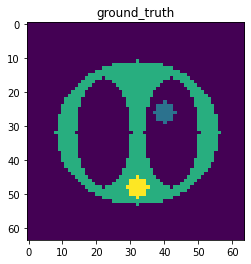

In [5]:
slice = image.get_lengths()[1]//2 # middle slice
plot_show_save(image, "ground_truth", slice = slice)

We're now ready to simulate our emission data. We have a .smc file containing information about the simulation. Please read the simind manual to learn about the many different options available. These options can be altered using either the change command (type "change input.smc into the terminal) or using switches \
The syntax for reconstruction is as follows:
`simind input_file_prefix outpute_files_prefix`
This can be followed by switches seperated by forward slashes such as below \*\
\* Unfortunately this causes some trible with Linux & MacOS file directories. The SIMIND manual claims that two backslashed '\\' can be used in place of a forward slash that is part of a file directory, but I haven't found this to be the case

The following bash command defines a .smc file `input.smc` follwed by a prefix for output files `output` \
Switches are then used to define:
* /NN: a multiplier for the number of histories per projection (which is calculated using the sum of all voxel values)
* /PX: defines the image pixel size in the i,j direction (transverse in this case) - im.voxel_sizes()
* /FS: defines the prefix for the .smi emission image file
* /FD: defines the prefix for rhe .dmi attenuation image file # note: we've simulated this without attenuation

In [6]:
%%bash
simind input output/NN:1/PX:0.4/FS:emission_image.smi




              SIMIND Monte Carlo Simulation Program    V7.0.1
------------------------------------------------------------------------------
 Phantom(S): h2o       Crystal...: nai       InputFile.: input             
 Phantom(B): bone      BackScatt.: pmt       OutputFile: output            
 Collimator: pb_sb2    SourceRout: smap      SourceFile: emission_image    
 Cover.....: al        ScoreRout.: scattwin  DensityMap: attn_simind       
------------------------------------------------------------------------------
 PhotonEnergy.......: 140          ge-legp  PhotonsPerProj....: 213633         
 EnergyResolution...: 8.8          SPECT    Activity..........: 1              
 MaxScatterOrder....: 3            BScatt   DetectorLenght....: 25             
 DetectorWidth......: 0            Phantom  DetectorHeight....: 0.953          
 UpperEneWindowTresh: 154          Resolut  Distance to det...: 25             
 LowerEneWindowTresh: 126          Header   ShiftSource X.....: 0        

And (assuming the preious cell ran) we have now simulated our SPECT data!\
Next we need to get this data into a format the SIRF will recognise. Luckily we have a script ready that does this for us.
This script changes a few lines in the data's header file and the header file suffix. Differences between the conventions of interfiles in SIMIND and STIR/SIRF can be found in Rebecca's notes.

SIMIND (with the current scoring routine) will output an air, scatter and total sinogram. We're interested in the total

In [7]:
%%bash
sh ./convertSIMINDToSTIR.sh output_tot_w1.h00

Output in output_tot_w1.hs


We can now view the resulting sinogram

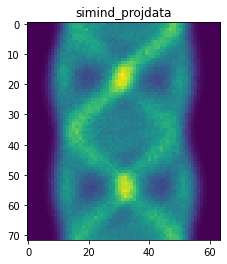

In [8]:
simind_projdata =  stir.ProjData.read_from_file("output_tot_w1.hs")

slice = simind_projdata.get_num_sinograms()//2
plot_show_save(simind_projdata, "simind_projdata", slice)

OK, so now we have our projection data in a format that SIRF likes, we can go about reconstructing the data.

In order to do this we first need to create our acqusition model matrix

In [9]:
acq_model_matrix = stir.ProjMatrixByBinSPECTUB() # create a SPECT porjection matrix object
acq_model_matrix.set_keep_all_views_in_cache(False) # This keeps views in memory for a speed improvement
acq_model_matrix.set_resolution_model(0.1,0.1) # Set a resolution model (just a guess!)
acq_model_matrix.set_up(simind_projdata.get_proj_data_info(), image)


INFO: 3D PSF Correction. Parallel geometry

Parameters of SPECT UB matrix: (in cm)
Image grid side row: 64	col: 64	transverse voxel_size: 0.4
Number of slices: 64	slice_thickness: 0.4
Number of bins: 64	bin size: 0.4	axial size: 0.4
Number of angles: 72	Angle increment: -5	First angle: 90
Number of subsets: 72
Rotation radii: {25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25}
Minimum weight: 0


INFO: Done estimating size of matrix. Execution (CPU) time 0.48 s 


In [10]:
projector = stir.ProjectorByBinPairUsingProjMatrixByBin(acq_model_matrix)
projector.set_up(simind_projdata.get_proj_data_info(), image)

<Swig Object of type 'stir::Succeeded *' at 0x7f7a6ce213f0>


INFO: Processing view 0 of segment 0

INFO: Computing matrix elements for view 0

INFO: total number of non-zero weights in this view: 3351136, estimated size: 32.3495 MB

INFO: Weight matrix calculation done. time 0.05 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.08 (s)

INFO: Processing view 1 of segment 0

INFO: Computing matrix elements for view 1

INFO: total number of non-zero weights in this view: 2932928, estimated size: 28.3612 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: Processing view 2 of segment 0

INFO: Computing matrix elements for view 2

INFO: total number of non-zero weights in this view: 2907722, estimated size: 28.1208 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: Processing view 3 of segment 0

INFO: Computing matrix elements for view 3

INFO:

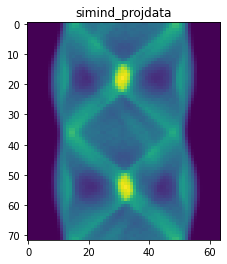

In [11]:
stir_projdata = stir.ProjDataInMemory(simind_projdata.get_exam_info(),
                                simind_projdata.get_proj_data_info())

projector.get_forward_projector().forward_project(stir_projdata, image)

slice = simind_projdata.get_num_sinograms()//2
plot_show_save(stir_projdata, "simind_projdata", slice)

And we can finally backproject the data


INFO: Processing view 0 of segment 0

INFO: Computing matrix elements for view 0

INFO: total number of non-zero weights in this view: 3351136, estimated size: 32.3495 MB

INFO: Weight matrix calculation done. time 0.05 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.07 (s)

INFO: Processing view 1 of segment 0

INFO: Computing matrix elements for view 1

INFO: total number of non-zero weights in this view: 2932928, estimated size: 28.3612 MB

INFO: Weight matrix calculation done. time 0.05 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.07 (s)

INFO: Processing view 2 of segment 0

INFO: Computing matrix elements for view 2

INFO: total number of non-zero weights in this view: 2907722, estimated size: 28.1208 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: Processing view 3 of segment 0

INFO: Computing matrix elements for view 3

INFO:

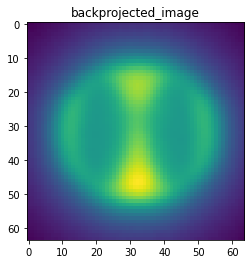

In [12]:
# create a dummy image to fill with out reconstructed image
target = image.get_empty_copy()
target.fill(1)

projector.get_back_projector().back_project(target, simind_projdata)
slice = target.get_lengths()[1]//2 # middle slice
plot_show_save(target, "backprojected_image", slice = slice)

In [13]:
# create our objective function
obj_function = stir.PoissonLogLikelihoodWithLinearModelForMeanAndProjData3DFloat()
obj_function.set_proj_data_sptr(simind_projdata)
obj_function.set_projector_pair_sptr(projector)

# and now our reconstruction object
recon = stir.OSMAPOSLReconstruction3DFloat()
recon.set_objective_function(obj_function)
recon.set_num_subsets(9)
recon.set_num_subiterations(9)
recon.set_max_num_full_iterations(1)

In [14]:
# create a dummy image to fill with out reconstructed image
target = image.get_empty_copy()
target.fill(1)

# and reconstruct
recon.set_up(target)
s = recon.reconstruct(target)


INFO: (subset)sensitivity filename(s) not set so I will compute the (subset)sensitivities

INFO: Computing sensitivity

INFO: calculating segment_num: 0, view_num: 0

INFO: Computing matrix elements for view 0

INFO: total number of non-zero weights in this view: 3351136, estimated size: 32.3495 MB

INFO: Weight matrix calculation done. time 0.05 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.07 (s)

INFO: calculating segment_num: 0, view_num: 9

INFO: Computing matrix elements for view 9

INFO: total number of non-zero weights in this view: 2725146, estimated size: 26.3796 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: calculating segment_num: 0, view_num: 18

INFO: Computing matrix elements for view 18

INFO: total number of non-zero weights in this view: 3351136, estimated size: 32.3495 MB

INFO: Weight matrix calculation done. time 0.05 (s)

INFO: Total time 

Total CPU Time 5.82secs


 segment_num: 0, view_num: 37

INFO: Computing matrix elements for view 37

INFO: total number of non-zero weights in this view: 2932928, estimated size: 28.3612 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: calculating segment_num: 0, view_num: 46

INFO: Computing matrix elements for view 46

INFO: total number of non-zero weights in this view: 2736736, estimated size: 26.4902 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: calculating segment_num: 0, view_num: 55

INFO: Computing matrix elements for view 55

INFO: total number of non-zero weights in this view: 2932928, estimated size: 28.3612 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: calculating segment_num: 0, view_num: 64

INFO: Computing matrix e

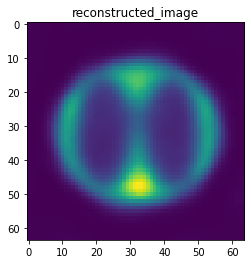

In [15]:
slice = stir_projdata.get_num_sinograms()//2
# The recpnstructed image
plot_show_save((target), "reconstructed_image", slice = slice)

In [16]:
### delete any rogue projections from the reconstruction
import glob
import os

for f in glob.glob("tmp*"):
    os.remove(f)